## Heart disease patients clasterization
Tymoteusz Urban, Karolina Mączka

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import fcluster, linkage
from tabulate import tabulate
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import SpectralClustering

In [28]:
import warnings
warnings.filterwarnings("ignore")

### Dividing dataset and saving to files

In [29]:
df = pd.read_csv('heart_disease_patients.csv')

# Split data into train and remaining data
X_train, X_remaining = train_test_split(df, test_size=0.3, random_state=42)

# Split remaining data into test and validation sets
X_test, X_validation = train_test_split(X_remaining, test_size=0.5, random_state=42)

train_df = pd.DataFrame(X_train) 
train_df.to_csv('train.csv', index=False)

test_df = pd.DataFrame(X_test)  
test_df.to_csv('test.csv', index=False)

validation_df = pd.DataFrame(X_validation)
validation_df.to_csv('validation.csv', index=False)

## Data exploration

In [30]:
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df.copy()
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   65    1   1       138   282    1        2      174      0      1.4      2
1   62    1   4       120   267    0        0       99      1      1.8      2
2   57    1   3       150   168    0        0      174      0      1.6      1
3   57    1   4       140   192    0        0      148      0      0.4      2
4   58    0   4       100   248    0        2      122      0      1.0      2


1. age - age in years (male risk > 55, female risk > 65)
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital, 80 norm, 90< overpressure)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false, diabetes)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping, flat is good)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    int64  
 1   sex       212 non-null    int64  
 2   cp        212 non-null    int64  
 3   trestbps  212 non-null    int64  
 4   chol      212 non-null    int64  
 5   fbs       212 non-null    int64  
 6   restecg   212 non-null    int64  
 7   thalach   212 non-null    int64  
 8   exang     212 non-null    int64  
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.3 KB


In [32]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

There are no null values, all variables are clean and properly prepared.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>],
       [<AxesSubplot:title={'center':'trestbps'}>,
        <AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>],
       [<AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>,
        <AxesSubplot:title={'center':'exang'}>],
       [<AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>, <AxesSubplot:>]],
      dtype=object)

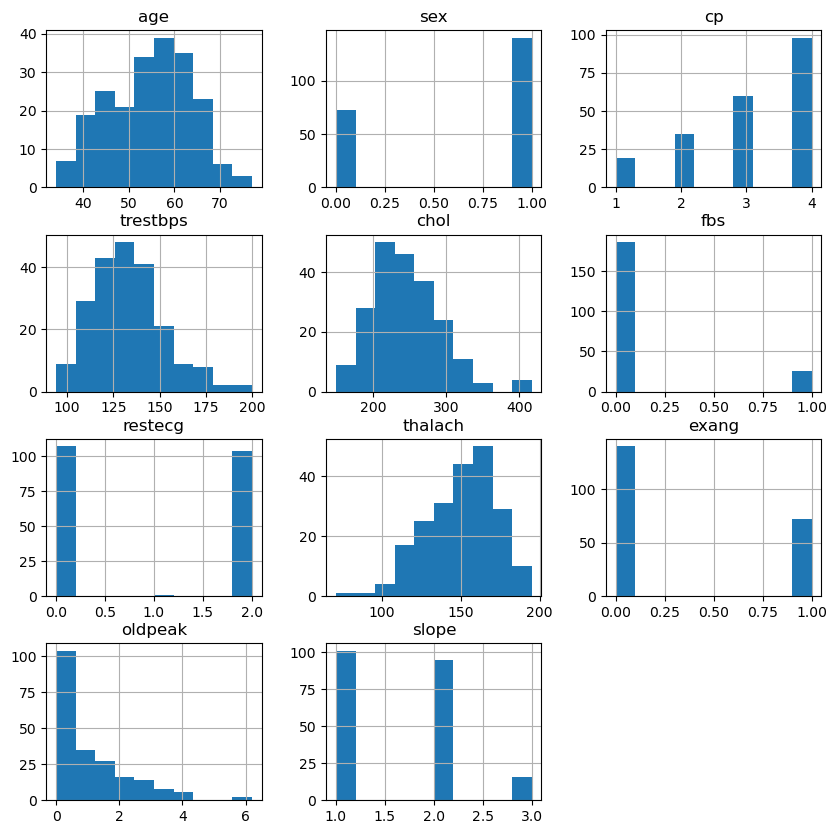

In [33]:
df.hist(figsize=(10,10))

Restecg looks strange as if there were no values 1. Let's check it:

In [34]:
df['restecg'].value_counts()

0    107
2    104
1      1
Name: restecg, dtype: int64

There is only one value 1, so we will treat it as an outlier.

<AxesSubplot:>

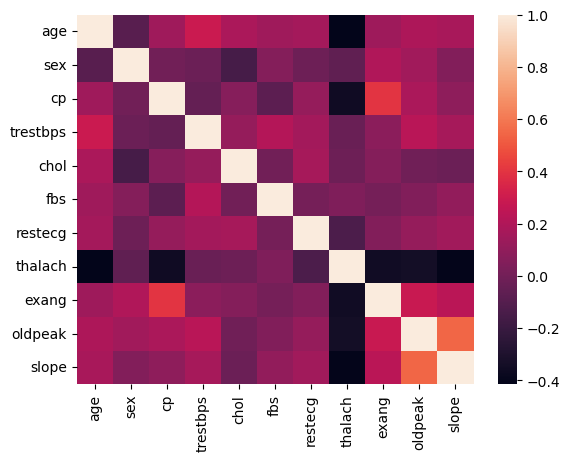

In [35]:
sns.heatmap(df.corr())

There is quite high correlation between oldpeak and slope and also between cp and exang, but is it big enough to delete any of the columns? Also, there is negative correlation between thalach and: age, cp, exang, oldpeak, slope.

In [36]:
print(f"oldpeak and slope correlation: {df[['oldpeak', 'slope']].corr().iloc[0,1]}")
print(f"cp and exang correlation: {df[['cp', 'exang']].corr().iloc[0,1]}")
print(f"thalach and age correlation: {df[['thalach', 'age']].corr().iloc[0,1]}")
print(f"thalach and slope correlation: {df[['thalach', 'slope']].corr().iloc[0,1]}")

oldpeak and slope correlation: 0.5458278072906251
cp and exang correlation: 0.39916290470356114
thalach and age correlation: -0.4149739322362583
thalach and slope correlation: -0.40644733868269406


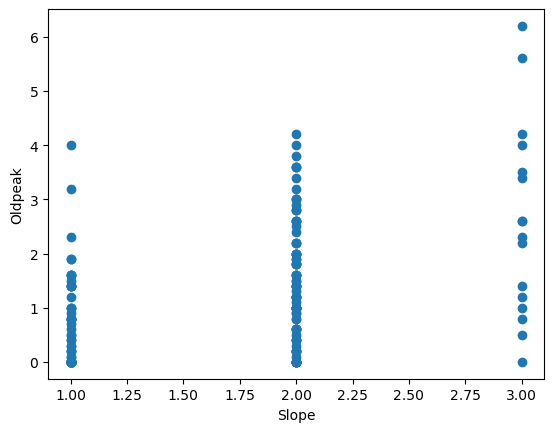

In [37]:
plt.scatter(df['slope'], df['oldpeak'])
plt.xlabel('Slope')
plt.ylabel('Oldpeak')
plt.show()

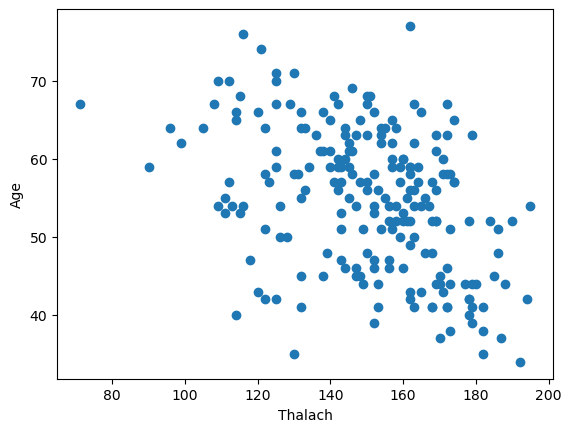

In [38]:
plt.scatter(df['thalach'], df['age'])
plt.xlabel('Thalach')
plt.ylabel('Age')
plt.show()

In [39]:
# Another approach
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [40]:
calc_vif(df)

,variables,VIF
0,age,39.346948
1,sex,3.095046
2,cp,12.426015
3,trestbps,58.483209
4,chol,29.128519
5,fbs,1.200710
6,restecg,2.136638
7,thalach,34.543369
8,exang,2.081073
9,oldpeak,2.720192


Should variables should we drop? According to traditional correlation between variables it could be slope, but after calculating VIF it seems that age, trestbps, chol and thalach are highly correlated with the other variables. So from both methods thalach column is a candidate to delete. But after rethinking we came to conclusion with our validation team that none should be deleted as all are essential for medical analysis 

## Preprocessing

In [41]:
# Outliers removal - replace lower_bound and upper_bound, only numeric columns
def replace_outliers(data, k=1.5):
    """
    Removes outliers from a pandas DataFrame using the interquartile range (IQR) method.

    :param data: dataframe
    :param k: A multiplier to adjust the outlier threshold. By default, k is set to 1.5.
    :return: dataframe
    """
    data = data.copy()
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound

    value = data['restecg'].value_counts().idxmax()
    data['restecg'] = data['restecg'].replace(1, value)
    data['restecg'] = data['restecg'].replace(2, 1) # make restecg a boolean column: 1 means hypertrophy, 0 is normal

    return data

In [42]:
#  Encode chest pain type column
def encode_columns(data):
    """
        Encodes categorical column cp (chest pain type)

    :param data: Dataframe
    :return: Encoded dataframe
    """
    data = data.copy()
    data = pd.get_dummies(data, columns=['cp'], prefix='cp', dtype=int)
    data = data.rename(columns={"cp_1": "cp_typ_ang", "cp_2": "cp_atyp_ang", "cp_3": "cp_non_ang", "cp_4": "cp_asympt"})
    return data

In [43]:
# Instead manual deletion of variables we could use PCA for reducing dimensionality
def remove_overshadowing(data):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.

    :param data: dataframe
    :return:
            A reduced version of the input DataFrame, containing the first n principal components
            where n is the smallest number of components that explain at least 95% of the variance in the data.
            The columns of the new DataFrame are named "PC1", "PC2", etc.

    """
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(data)

    # Determine the number of principal components to retain
    explained_variances = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variances > 0.95) + 1

    # Retain the first n principal components
    X_reduced = X_pca[:, :n_components]

    # Convert back to a pandas DataFrame
    df_reduced = pd.DataFrame(X_reduced, columns=["PC"+str(i) for i in range(1, n_components+1)])
    
    return df_reduced

We will also need to scale our data - we can try 3 different ways to do it. We will test it later.

In [44]:
def standarize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X


def normalize(X):
    normalizer = Normalizer()
    X_normalized = normalizer.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)
    return X


def minmax(X):
    minmaxer = MinMaxScaler()
    X_scaled = minmaxer.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X

In [45]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,65,1,1,138,282,1,2,174,0,1.4,2
1,62,1,4,120,267,0,0,99,1,1.8,2
2,57,1,3,150,168,0,0,174,0,1.6,1
3,57,1,4,140,192,0,0,148,0,0.4,2
4,58,0,4,100,248,0,2,122,0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
207,54,1,2,192,283,0,2,195,0,0.0,1
208,67,1,4,125,254,1,0,163,0,0.2,2
209,59,1,4,140,177,0,0,162,1,0.0,1
210,61,1,4,140,207,0,2,138,1,1.9,1


In [46]:
# Let's check our functions
df_prep = replace_outliers(raw_data)
df_prep = encode_columns(df_prep)
df_prep

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,65.0,1,138.00,282.0,1,1,174.0,0,1.4,2,1,0,0,0
1,62.0,1,120.00,267.0,0,0,99.0,1,1.8,2,0,0,0,1
2,57.0,1,150.00,168.0,0,0,174.0,0,1.6,1,0,0,1,0
3,57.0,1,140.00,192.0,0,0,148.0,0,0.4,2,0,0,0,1
4,58.0,0,100.00,248.0,0,1,122.0,0,1.0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,54.0,1,171.25,283.0,0,1,195.0,0,0.0,1,0,1,0,0
208,67.0,1,125.00,254.0,1,0,163.0,0,0.2,2,0,0,0,1
209,59.0,1,140.00,177.0,0,0,162.0,1,0.0,1,0,0,0,1
210,61.0,1,140.00,207.0,0,1,138.0,1,1.9,1,0,0,0,1


In [47]:
minmax(df_prep)

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_typ_ang,cp_atyp_ang,cp_non_ang,cp_asympt
0,0.720930,1.0,0.569579,0.617169,1.0,1.0,0.793103,0.0,0.350,0.5,1.0,0.0,0.0,0.0
1,0.651163,1.0,0.336570,0.547564,0.0,0.0,0.054187,1.0,0.450,0.5,0.0,0.0,0.0,1.0
2,0.534884,1.0,0.724919,0.088167,0.0,0.0,0.793103,0.0,0.400,0.0,0.0,0.0,1.0,0.0
3,0.534884,1.0,0.595469,0.199536,0.0,0.0,0.536946,0.0,0.100,0.5,0.0,0.0,0.0,1.0
4,0.558140,0.0,0.077670,0.459397,0.0,1.0,0.280788,0.0,0.250,0.5,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.465116,1.0,1.000000,0.621810,0.0,1.0,1.000000,0.0,0.000,0.0,0.0,1.0,0.0,0.0
208,0.767442,1.0,0.401294,0.487239,1.0,0.0,0.684729,0.0,0.050,0.5,0.0,0.0,0.0,1.0
209,0.581395,1.0,0.595469,0.129930,0.0,0.0,0.674877,1.0,0.000,0.0,0.0,0.0,0.0,1.0
210,0.627907,1.0,0.595469,0.269142,0.0,1.0,0.438424,1.0,0.475,0.0,0.0,0.0,0.0,1.0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'trestbps'}>,
        <AxesSubplot:title={'center':'chol'}>],
       [<AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>,
        <AxesSubplot:title={'center':'exang'}>],
       [<AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'cp_typ_ang'}>,
        <AxesSubplot:title={'center':'cp_atyp_ang'}>],
       [<AxesSubplot:title={'center':'cp_non_ang'}>,
        <AxesSubplot:title={'center':'cp_asympt'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

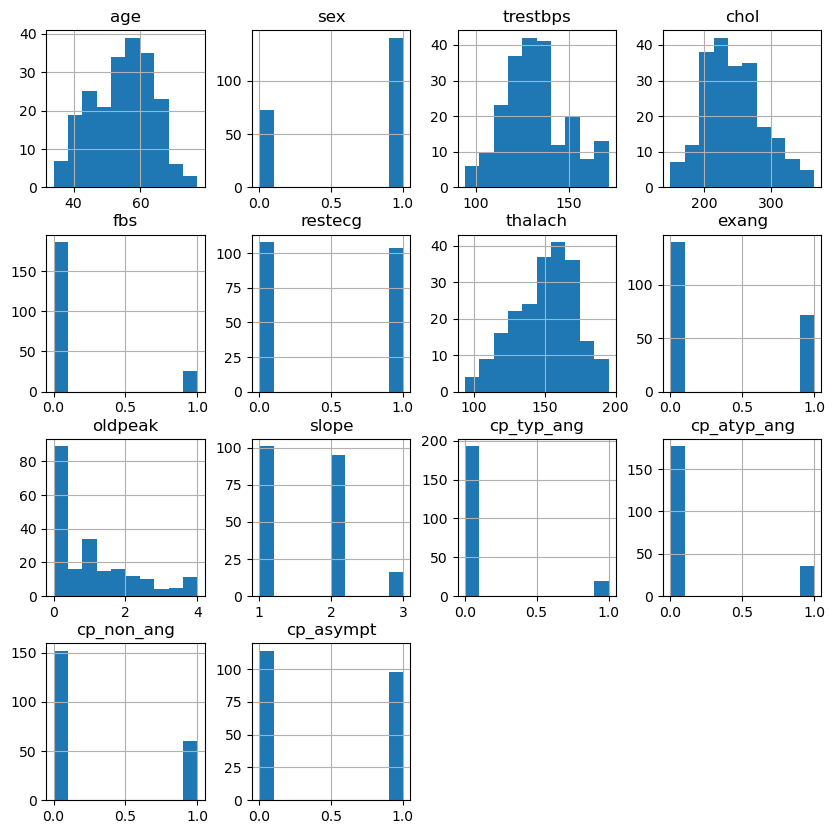

In [48]:
df_prep.hist(figsize=(10,10))

In [49]:
# Test PCA
df_pca = replace_outliers(raw_data)
df_pca = encode_columns(df_pca)
df_pca = minmax(df_pca)
df_pca = remove_overshadowing(df_pca)
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.132617,0.426787,0.433962,0.891037,0.798188,-0.388303,0.527402,0.477042,-0.117244,-0.160859
1,0.910406,-0.637786,0.181633,-0.365014,0.062484,0.035384,-0.166866,-0.103250,0.145059,-0.310922
2,-0.799262,-0.282356,0.649245,-0.174409,-0.256103,-0.225534,-0.086299,-0.021977,0.214752,0.316420
3,0.282105,-0.522200,-0.096707,-0.033347,-0.163912,-0.664081,-0.012473,-0.203405,0.036688,-0.112053
4,0.382437,0.677170,-0.691201,-0.180314,-0.086393,-0.344277,-0.123727,-0.218404,-0.274267,-0.327804
...,...,...,...,...,...,...,...,...,...,...
207,-0.465364,0.065390,-0.357721,1.063195,-0.126054,0.416202,0.122289,-0.048420,0.456757,0.366300
208,0.248736,-0.460210,0.045179,-0.020140,0.167596,-0.678671,0.897341,-0.256596,-0.059555,-0.280164
209,0.645060,-0.750013,0.022189,-0.262070,-0.342125,0.113274,0.166023,0.338142,0.042257,0.007272
210,1.006905,0.098332,0.118930,0.163508,-0.322555,0.266672,0.046522,0.172808,0.122399,0.143866


<AxesSubplot:>

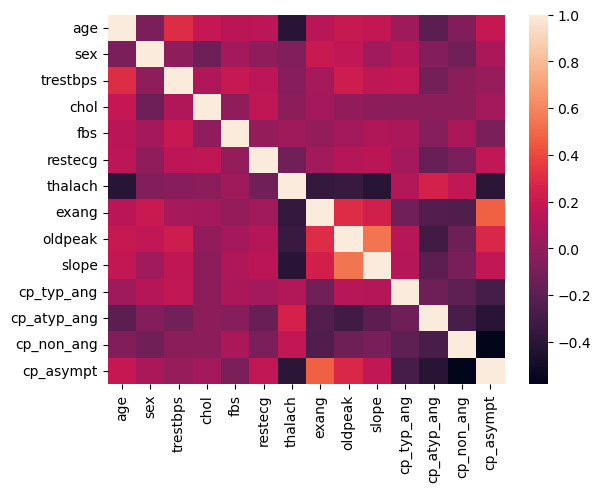

In [50]:
sns.heatmap(df_prep.corr())

Actually after tests we had to abandon encoding cp column, because models were doing clustering based only on this one column. So after all we are leaving it as is.

## Number of clusters

In [123]:
# We will use functions from other python files, so we don't have to run whole notebook every time
from preprocessing import standarize, minmax, normalize, replace_outliers, preprocessing, remove_id, encode_cp
from KMeans import k_means_alg

First we prepare methods for finding optimal number of clusters

In [124]:
def num_of_clus_elbow(data) -> int:
    """
        Finds optimal number of clusters using elbow method.

        :param data: dataframe
        :return: number of clusters
    """
    sum_of_squared_distances = []
    K = range(1, 10)
    for num_clusters in K:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    # finding elbow point
    sd = np.diff(sum_of_squared_distances, 2)
    elbow_point = np.argmax(sd) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), sum_of_squared_distances, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return elbow_point

In [125]:
def num_of_clus_silhouette(data) -> int:
    """
    Finds optimal number of clusters using silhouette method.

    :param data: dataframe
    :return: number of clusters
    """
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    silhouette_point = np.argmax(silhouette_scores) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    return silhouette_point

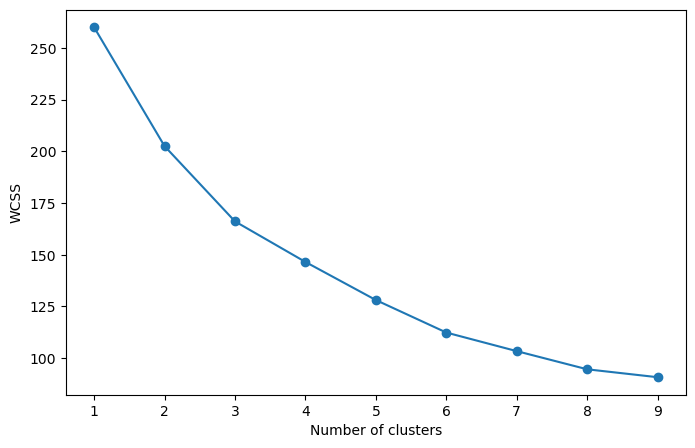

Elbow method: 2


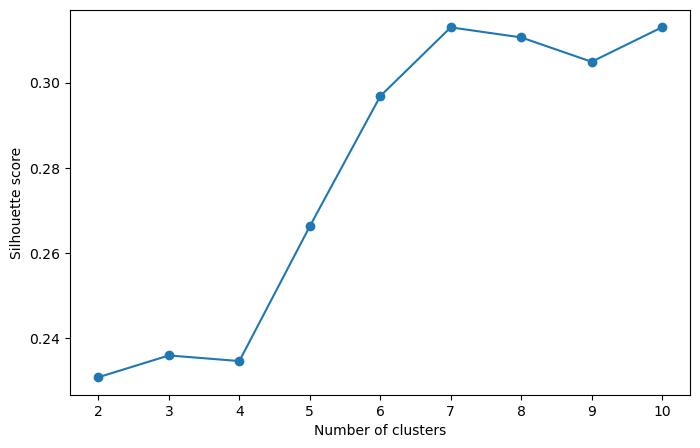

Silhouette method: 10


In [142]:
# Let's check elbow method
df_clusters = replace_outliers(raw_data)
df_clusters = minmax(df_clusters)
df_clusters = remove_overshadowing(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

We can see that returned values are different. Now we can test it on a baseline model:

In [143]:
for i in [2,4,7,10]:
    dfkmeans, model = k_means_alg(df_clusters, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_clusters, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_clusters, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_clusters, y_kmeans)}")

Number of clusters: 2
silhouette score: 0.23085622379426912
calinski harabasz score: 59.58829203587511
davies bouldin score: 1.7221735889095804
Number of clusters: 4
silhouette score: 0.23464852353148383
calinski harabasz score: 52.9610133404455
davies bouldin score: 1.4137107925080357
Number of clusters: 7
silhouette score: 0.31294702552159487
calinski harabasz score: 51.554274758534795
davies bouldin score: 1.2938164680253088
Number of clusters: 10
silhouette score: 0.31298135708632374
calinski harabasz score: 45.120894314972894
davies bouldin score: 1.2562811589677891


We can see that results are the best for 7 clusters. Now let's check how preprocessing influences clusters and score.

In [146]:
processing = ['stand', 'minmax', 'norm']
for proc in processing:
    print(f'Processing: {proc}')
    df_proc = preprocessing(raw_data, encode=False, process=proc)
    dfkmeans, model = k_means_alg(df_proc, num_clusters=7)
    y = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_proc, y)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_proc, y)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_proc, y)}")

Processing: stand
Number of clusters: 7
silhouette score: 0.1358814677562635
calinski harabasz score: 25.139613936964295
davies bouldin score: 1.9114422894174656
Processing: minmax
Number of clusters: 7
silhouette score: 0.31294702552159487
calinski harabasz score: 51.554274758534795
davies bouldin score: 1.2938164680253088
Processing: norm
Number of clusters: 7
silhouette score: 0.2804065596623967
calinski harabasz score: 125.45944749597398
davies bouldin score: 1.0045016016477173


Results vary depending on processing used. Normalizer has the best results, but we can see that normalized data still varies a lot:

In [132]:
normalize(raw_data).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.178178,0.002741,0.002741,0.378285,0.773018,0.002741,0.005482,0.476968,0.000000,0.003838,0.005482
1,0.196692,0.003172,0.012690,0.380695,0.847046,0.000000,0.000000,0.314073,0.003172,0.005710,0.006345
2,0.196362,0.003445,0.010335,0.516742,0.578751,0.000000,0.000000,0.599421,0.000000,0.005512,0.003445
3,0.199493,0.003500,0.014000,0.489983,0.671977,0.000000,0.000000,0.517983,0.000000,0.001400,0.007000
4,0.193573,0.000000,0.013350,0.333747,0.827693,0.000000,0.006675,0.407171,0.000000,0.003337,0.006675


For example values in sex column are around 0.003 while in chol or thalach values are way bigger. Thus, minmax scaler is the most reasonable scaler. Last question is if we should use PCA for reducing dimensionality.

In [147]:
df_pca = preprocessing(raw_data, encode=False, process='minmax')
dfkmeans, model = k_means_alg(df_pca, num_clusters=7)
y_kmeans = dfkmeans['label']
print(f"silhouette score: {silhouette_score(df_pca, y_kmeans)}")
print(f"calinski harabasz score: {calinski_harabasz_score(df_pca, y_kmeans)}")
print(f"davies bouldin score: {davies_bouldin_score(df_pca, y_kmeans)}")

Number of clusters: 7
silhouette score: 0.31294702552159487
calinski harabasz score: 51.554274758534795
davies bouldin score: 1.2938164680253088


We can see that PCA not only reduces dimensions, but also improves scores.

This whole time we have been replacing outliers. However, validation team stated that in medical data outliers are very important and we should not remove them. Let's check the scores if you do not use rep_out option in preprocessing:

In [148]:
df_pca = preprocessing(raw_data, rep_out=False, encode=False, process='minmax')
dfkmeans, model = k_means_alg(df_pca, num_clusters=7)
y_kmeans = dfkmeans['label']
print(f"silhouette score: {silhouette_score(df_pca, y_kmeans)}")
print(f"calinski harabasz score: {calinski_harabasz_score(df_pca, y_kmeans)}")
print(f"davies bouldin score: {davies_bouldin_score(df_pca, y_kmeans)}")

Number of clusters: 7
silhouette score: 0.3437519614251537
calinski harabasz score: 58.294138843426566
davies bouldin score: 1.213327677179781


Scores are better and we do not lose important data. But preprocessing affects optimal number of clusters so we should check them again:

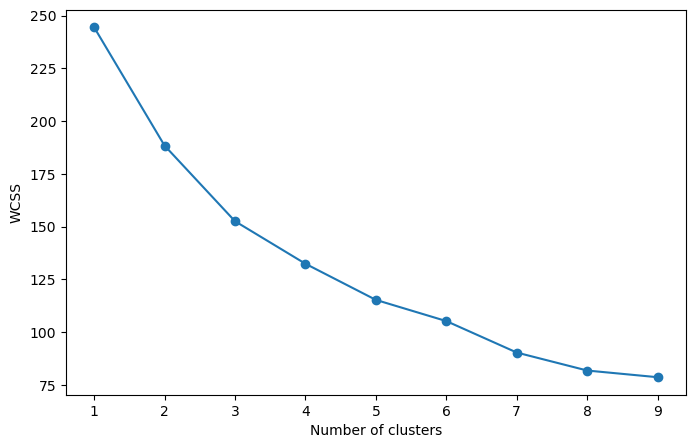

Elbow method: 2


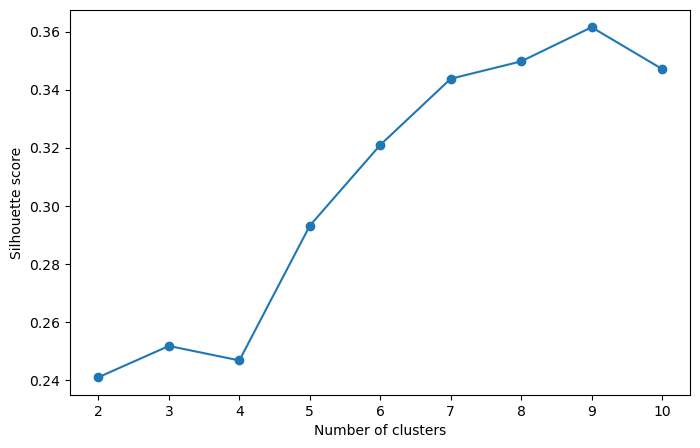

Silhouette method: 9


In [150]:
# Let's check elbow method
df_clusters = minmax(raw_data)
df_clusters = remove_overshadowing(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

Chart looks a little bit different, the more clusters, the better silhouette score. However we have to draw a line somewhere. That said in preprocessing we will stick to minmax scaler and pca and we will be using 7 clusters.

## Algorithms

In [205]:
from metrices import metrices
from dbscan import dbscan
from Evaluation import medians_for_clusters
from preprocessing import preprocessing
from KMeans import k_means_alg
from other_algorithms import k_medoids_alg, aglomerative_alg, minibatch_alg, gmm_alg

In [206]:
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df.copy()
df = preprocessing(raw_data, rep_out=False, encode=False, cp=False, process='minmax')
columns=['method', 'min dist btw cl', 'avg dist in cl', 'std dev dist in cl', 'silhouette', 'cal-har', 'dav-bou']
results = pd.DataFrame(columns=columns)

### Kmeans

In [207]:
results_df = ['Kmeans']

df_kmeans, model = k_means_alg(df, num_clusters=7)
y_kmeans = df_kmeans['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_kmeans)}')
    results_df.append(round(metrices[metric](df, y_kmeans), 3))
print("-----")
print("Medians:")
df_kmeans_medians = raw_data.copy()
df_kmeans_medians['label'] = y_kmeans
print(medians_for_clusters(df_kmeans_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Number of clusters: 7
Minimal distance between clusters: 0.6759568429818261
Average distance between points in the same class: 0.8805018696591459
Standard deviation of distance between points in the same class: 0.12486617512585098
Silhouette score: 0.3437519614251537
Calinski-Harabasz index: 58.294138843426566
Davies Bouldin index: 1.213327677179781
-----
Medians:
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      58.0  1.0  4.0     129.0  256.0  0.0      2.0    131.5    1.0     1.70   
1      52.0  1.0  3.0     125.0  229.0  0.0      0.0    162.0    0.0     0.30   
2      59.0  0.0  4.0     142.0  249.0  0.0      2.0    150.0    1.0     1.00   
3      58.0  0.0  3.0     135.0  258.0  0.0      2.0    157.0    0.0     0.60   
4      55.0  1.0  4.0     130.0  239.0  0.0      0.0    143.0    1.0     1.40   
5      55.0  1.0  3.0     131.0  239.0  0.0      2.0    157.5    0

### KMedoids

In [208]:
results_df = ['KMedoids']

df_medoids, model = k_medoids_alg(df, num_clusters=7)
y_kmedoids = df_medoids['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_kmedoids)}')
    results_df.append(round(metrices[metric](df, y_kmedoids), 3))
df_medoids_medians = raw_data.copy()
df_medoids_medians['label'] = y_kmedoids
print(medians_for_clusters(df_medoids_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Number of clusters: 7
Minimal distance between clusters: 0.19848026068605462
Average distance between points in the same class: 1.001056959180127
Standard deviation of distance between points in the same class: 0.08665877981157048
Silhouette score: 0.13403906125825524
Calinski-Harabasz index: 33.334283134923346
Davies Bouldin index: 2.3822870485403778
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      42.0  1.0  2.5     120.0  223.0  0.0      0.0    168.5    0.0     0.00   
1      57.5  1.0  4.0     132.0  257.5  0.0      2.0    139.0    1.0     1.55   
2      58.0  1.0  2.0     154.0  232.0  0.0      2.0    164.0    0.0     1.00   
3      59.0  1.0  4.0     132.0  243.0  0.0      0.0    143.0    1.0     1.20   
4      62.0  1.0  3.0     140.0  248.0  0.0      2.0    150.0    0.0     1.30   
5      57.0  1.0  3.0     132.0  231.0  0.0      0.0    158.0    0.0     0.80  

### Mini Batch

In [209]:
results_df = ['Mini Batch']

df_mini, model = minibatch_alg(df, num_clusters=7)
y_mini = df_mini['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_mini)}')
    results_df.append(round(metrices[metric](df, y_mini), 3))
    df_kmeans_medians = raw_data.copy()

df_mini_medians = raw_data.copy()
df_mini_medians['label'] = y_mini
print(medians_for_clusters(df_mini_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 0.6759568429818261
Average distance between points in the same class: 0.8752718872186751
Standard deviation of distance between points in the same class: 0.15144657988634072
Silhouette score: 0.33008715157062474
Calinski-Harabasz index: 58.20888588493815
Davies Bouldin index: 1.1818183110435654
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      54.0  1.0  3.0     130.0  243.5  0.0      2.0    160.5    0.0     0.45   
1      58.0  1.0  4.0     129.0  256.0  0.0      2.0    131.5    1.0     1.70   
2      54.0  0.0  3.0     125.0  221.5  0.0      0.0    163.0    0.0     0.10   
3      49.0  1.0  3.0     122.0  230.5  0.0      0.0    161.0    0.0     0.05   
4      57.0  0.0  3.0     135.0  264.0  0.0      2.0    153.0    0.0     0.60   
5      58.0  1.0  4.0     132.0  242.0  0.0      0.0    143.0    1.0     1.30   
6      59.0  1.0  3.0

### Aglomerative clustering

In [210]:
results_df = ['Agl Clust']

df_aglinks, model = aglomerative_alg(df, num_clusters=7, linkage = 'complete')
y_aglinks = df_aglinks['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_aglinks)}')
    results_df.append(round(metrices[metric](df, y_aglinks), 3))

df_aglinks_medians = raw_data.copy()
df_aglinks_medians['label'] = y_aglinks
print(medians_for_clusters(df_aglinks_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Number of clusters: 7
Minimal distance between clusters: 0.5493920597623592
Average distance between points in the same class: 0.9750878075072411
Standard deviation of distance between points in the same class: 0.15331550155086707
Silhouette score: 0.267877152399561
Calinski-Harabasz index: 41.66323996437559
Davies Bouldin index: 1.3493818057946818
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      52.0  1.0  3.0     130.0  234.0  0.0      0.0    160.0    0.0     0.40   
1      55.5  1.0  4.0     130.0  244.5  0.0      0.0    143.0    1.0     1.40   
2      58.0  0.0  3.0     145.0  285.5  1.0      2.0    149.0    0.0     0.90   
3      58.5  0.0  3.0     130.0  227.0  0.0      0.0    161.0    0.0     0.20   
4      58.0  1.0  4.0     128.0  259.0  0.0      2.0    132.0    1.0     1.50   
5      52.5  1.0  2.5     141.5  208.5  1.0      0.0    159.5    0.0     1.10   
6

### DBSCAN

In [211]:
results_df = ['DBSCAN']

df_dbscan, model = dbscan(df, 'minmax')
y_dbscan = df_dbscan['label']

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_dbscan)}')
    results_df.append(round(metrices[metric](df, y_dbscan), 3))

df_dbscan_medians = raw_data.copy()
df_dbscan_medians['label'] = y_dbscan
#print(medians_for_clusters(df_dbscan_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 0.5091843197694769
Average distance between points in the same class: 0.6028955132941675
Standard deviation of distance between points in the same class: 0.3239884861243685
Silhouette score: 0.27581067242053336
Calinski-Harabasz index: 25.152110156519832
Davies Bouldin index: 1.4384691695801504


### GMM

In [212]:
from sklearn.mixture import GaussianMixture
results_df = ['GMM']

gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=10)
y_gmm = gmm.fit_predict(df)

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_gmm)}')
    results_df.append(round(metrices[metric](df, y_gmm), 3))

df_gmm_medians = raw_data.copy()
df_gmm_medians['label'] = y_gmm
#print(medians_for_clusters(df_gmm_medians))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 0.5706742832494368
Average distance between points in the same class: 0.9378223592177299
Standard deviation of distance between points in the same class: 0.1328047244304438
Silhouette score: 0.33052045888862325
Calinski-Harabasz index: 53.401613836436724
Davies Bouldin index: 1.220660039386472


### Spectral

In [213]:
results_df = ['Spectral']

sc = SpectralClustering(n_clusters=7, random_state=0)
y_sc = sc.fit_predict(df)

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_sc)}')
    results_df.append(round(metrices[metric](df, y_sc), 3))

df_sc_medians = raw_data.copy()
df_sc_medians['label'] = y_sc

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 0.4141255581233981
Average distance between points in the same class: 0.8829168447089761
Standard deviation of distance between points in the same class: 0.22662385752289335
Silhouette score: 0.321976514723301
Calinski-Harabasz index: 56.70815344883389
Davies Bouldin index: 1.194365994746271


In [214]:
results

,method,min dist btw cl,avg dist in cl,std dev dist in cl,silhouette,cal-har,dav-bou
0,Kmeans,0.676,0.881,0.125,0.344,58.294,1.213
1,KMedoids,0.198,1.001,0.087,0.134,33.334,2.382
2,Mini Batch,0.676,0.875,0.151,0.33,58.209,1.182
3,Agl Clust,0.549,0.975,0.153,0.268,41.663,1.349
4,DBSCAN,0.509,0.603,0.324,0.276,25.152,1.438
5,GMM,0.571,0.938,0.133,0.331,53.402,1.221
6,Spectral,0.414,0.883,0.227,0.322,56.708,1.194


From those algorithms KMeans performs the best (1st in min dist btw clust, 3nd in avg dist in clust, 2nd in std dev in clust)

### Standard hierarchical clustering

In [215]:
data = df.to_numpy()

k = 7
linkage_methods = ['single', 'complete', 'average', 'ward']
columnsh=['min dist btw cl', 'avg dist in cl', 'std dev dist in cl', 'silhouette', 'cal-har', 'dav-bou']

resultsh = []
for method in linkage_methods:
    Z = linkage(data, method=method)
    labels = fcluster(Z, k, criterion='maxclust')

    row = [method]
    for metric in metrices:
        value = metrices[metric](df, labels)
        row.append(value)
    resultsh.append(row)

headers = ['Linkage Method'] + list(columnsh)
print(tabulate(resultsh, headers=headers, tablefmt='fancy_grid'))

╒══════════════════╤═══════════════════╤══════════════════╤══════════════════════╤══════════════╤═══════════╤═══════════╕
│ Linkage Method   │   min dist btw cl │   avg dist in cl │   std dev dist in cl │   silhouette │   cal-har │   dav-bou │
╞══════════════════╪═══════════════════╪══════════════════╪══════════════════════╪══════════════╪═══════════╪═══════════╡
│ single           │          1.00725  │       nan        │           nan        │    0.0115834 │   7.15688 │   1.0941  │
├──────────────────┼───────────────────┼──────────────────┼──────────────────────┼──────────────┼───────────┼───────────┤
│ complete         │          0.549392 │         0.975088 │             0.153316 │    0.267877  │  41.6632  │   1.34938 │
├──────────────────┼───────────────────┼──────────────────┼──────────────────────┼──────────────┼───────────┼───────────┤
│ average          │          0.73653  │       nan        │           nan        │    0.163755  │  18.5278  │   1.09267 │
├──────────────────┼────

Somehow we got nans in some metrices but no idea why. The results are worse anyway.

Dendogram

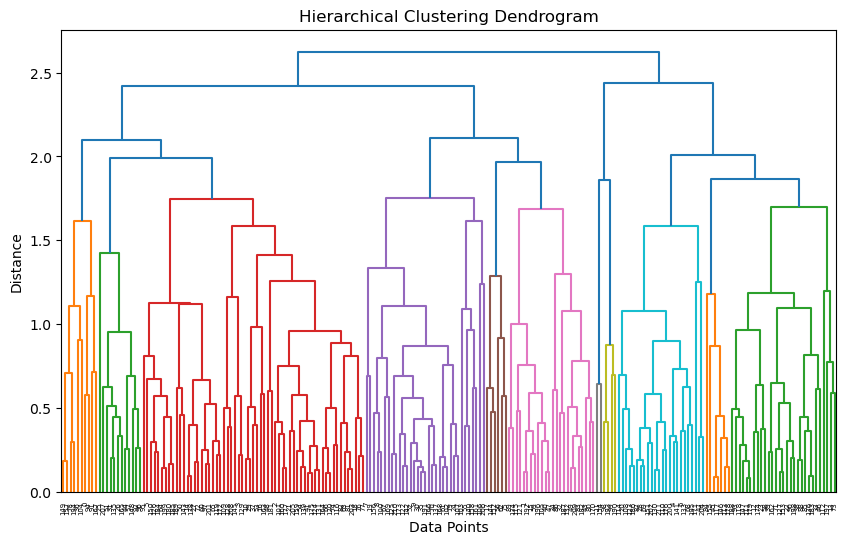

In [216]:
data = df.to_numpy()

Z = linkage(data, method='complete')

plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Hybrid with Kmeans

In [220]:
k=7
results_df = ['Hybrid']
agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='complete')
agg_labels = agg_cluster.fit_predict(df)

# Compute the center of each cluster
cluster_centers = []
for cluster in range(k):
    cluster_data = df[agg_labels == cluster]
    cluster_center = cluster_data.mean(axis=0)
    cluster_centers.append(cluster_center)

# Convert the cluster centers to a numpy array
cluster_centers = np.array(cluster_centers)

# Perform k-means clustering using the cluster centers as initial centers
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans_labels = kmeans.fit_predict(df)
kmeans_cluster_centers = kmeans.cluster_centers_

for metric in metrices:
    print(f'{metric}: {metrices[metric](df, kmeans_labels)}')
    results_df.append(round(metrices[metric](df, kmeans_labels), 3))

a = np.array(results_df)
results = pd.concat([results, pd.DataFrame(a[None], columns=columns)], ignore_index=True)

Minimal distance between clusters: 0.6759568429818261
Average distance between points in the same class: 0.9639785332989026
Standard deviation of distance between points in the same class: 0.16047290549963827
Silhouette score: 0.28837353814268674
Calinski-Harabasz index: 46.01252477972658
Davies Bouldin index: 1.2752976555770803


In [219]:
results

,method,min dist btw cl,avg dist in cl,std dev dist in cl,silhouette,cal-har,dav-bou
0,Kmeans,0.676,0.881,0.125,0.344,58.294,1.213
1,KMedoids,0.198,1.001,0.087,0.134,33.334,2.382
2,Mini Batch,0.676,0.875,0.151,0.33,58.209,1.182
3,Agl Clust,0.549,0.975,0.153,0.268,41.663,1.349
4,DBSCAN,0.509,0.603,0.324,0.276,25.152,1.438
5,GMM,0.571,0.938,0.133,0.331,53.402,1.221
6,Spectral,0.414,0.883,0.227,0.322,56.708,1.194
7,Hybrid,0.676,0.964,0.16,0.288,46.013,1.275


It did not help, results are a little bit worse. Maybe we can try to apply majority voting to multiple models.

In [221]:
def majority_voting(*labels):
    stacked_labels = np.vstack(labels)
    majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_labels)
    return majority_vote

For all subgroups

In [222]:
methods_list = [y_mini, y_gmm, y_kmeans, agg_labels, y_sc]
methods_list_names = ['y_mini', 'y_gmm', 'y_kmeans', 'agg_labels', 'y_sc']

In [223]:
from itertools import combinations

def get_subgroups(lst):
    subgroups = []
    n = len(lst)
    for group_size in range(1, n + 1):
        for subgroup in combinations(lst, group_size):
            subgroups.append(list(subgroup))
    return subgroups

In [224]:
subgroups = get_subgroups(methods_list)
subgroups_names = get_subgroups(methods_list_names)

In [225]:
table = np.zeros((len(subgroups), 6))

for i in range(len(subgroups)):
    y_maj_vote = majority_voting(subgroups[i])
    for index, key in enumerate(metrices):
        metric = metrices[key]
        val = round(metrices[key](df, y_maj_vote), 4)
        table[i, index] = val
        # print(f'{key}: {metrices[key](df, y_maj_vote)}')


Printing dataframe already filtered so we only get good results

In [231]:
column_names=['min dist btw cl', 'avg dist in cl', 'std dev dist in cl', 'silhouette', 'cal-har', 'dav-bou']

table_df = pd.DataFrame(table, columns=column_names)
table_df["subgroups"] = subgroups_names
column_names = table_df.columns.tolist()
last_column = column_names[-1]
column_names.remove(last_column)
new_column_order = [last_column] + column_names
table_df = table_df[new_column_order]
table_df = table_df[(table_df['min dist btw cl'] > 0.6) & (table_df['avg dist in cl'] < 1)]
table_df

,subgroups,min dist btw cl,avg dist in cl,std dev dist in cl,silhouette,cal-har,dav-bou
0,[y_mini],0.676,0.8753,0.1514,0.3301,58.2089,1.1818
2,[y_kmeans],0.676,0.8805,0.1249,0.3438,58.2941,1.2133
6,"[y_mini, y_kmeans]",0.676,0.9611,0.1150,0.2527,42.4486,1.3653
9,"[y_gmm, y_kmeans]",0.676,0.9733,0.1082,0.2712,52.6453,1.3277
15,"[y_mini, y_gmm, y_kmeans]",0.676,0.9546,0.1023,0.2547,42.6307,1.3155


It did not work out. To be honest it was not a good idea as there can be problems with numbering and disappearing clusters. Taking all the results into consideration we will stick to kmeans algorithm.

In [232]:
def means_for_clusters(df):
    means = df.groupby('label').mean()
    return means

In [237]:
final = raw_data.copy()
final['label'] = y_kmeans
print(medians_for_clusters(final))
print(means_for_clusters(final))

        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
0      58.0  1.0  4.0     129.0  256.0  0.0      2.0    131.5    1.0     1.70   
1      52.0  1.0  3.0     125.0  229.0  0.0      0.0    162.0    0.0     0.30   
2      59.0  0.0  4.0     142.0  249.0  0.0      2.0    150.0    1.0     1.00   
3      58.0  0.0  3.0     135.0  258.0  0.0      2.0    157.0    0.0     0.60   
4      55.0  1.0  4.0     130.0  239.0  0.0      0.0    143.0    1.0     1.40   
5      55.0  1.0  3.0     131.0  239.0  0.0      2.0    157.5    0.0     0.55   
6      54.0  0.0  3.0     125.0  221.5  0.0      0.0    163.0    0.0     0.10   

       slope  
label         
0        2.0  
1        1.0  
2        2.0  
3        2.0  
4        2.0  
5        2.0  
6        1.0  
             age  sex        cp    trestbps        chol       fbs   restecg  \
label                                                   

In [234]:
for metric in metrices:
    print(f'{metric}: {metrices[metric](df, y_kmeans)}')

Minimal distance between clusters: 0.6759568429818261
Average distance between points in the same class: 0.8805018696591459
Standard deviation of distance between points in the same class: 0.12486617512585098
Silhouette score: 0.3437519614251537
Calinski-Harabasz index: 58.294138843426566
Davies Bouldin index: 1.213327677179781


Summary

In [257]:
df_train = pd.read_csv('train.csv')
raw_data = df_train.copy()
df_train = preprocessing(df_train, rem_over=True, encode=False, rep_out=False, process='minmax')

In [258]:
mv_final = y_kmeans

Plots

In [259]:
fig1 = go.Figure(data=[go.Scatter3d(
    x=df_train['PC1'],
    y=df_train['PC2'],
    z=df_train['PC3'],
    mode='markers',
    marker=dict(size=4, color=mv_final)
)])

fig2 = go.Figure(data=[go.Scatter3d(
    x=df_train['PC1'],
    y=df_train['PC2'],
    z=df_train['PC4'],
    mode='markers',
    marker=dict(size=4, color=mv_final)
)])

fig1.update_layout(title_text="Visualization of 3 first principal components", scene=dict(
        xaxis=dict(title=df_train.columns[0]),
        yaxis=dict(title=df_train.columns[1]),
        zaxis=dict(title=df_train.columns[2])
    ))
fig1.update_xaxes(range=[-2, 2])
fig2.update_yaxes(range=[-2, 2])

fig2.update_layout(title_text="Visualization of 1, 2, 4 principal component", scene=dict(
        xaxis=dict(title=df_train.columns[0]),
        yaxis=dict(title=df_train.columns[1]),
        zaxis=dict(title=df_train.columns[3])
    ))
fig2.update_xaxes(range=[-2, 2])
fig2.update_yaxes(range=[-2, 2])

fig1.show()
fig2.show()


Boxplots for continuous plots

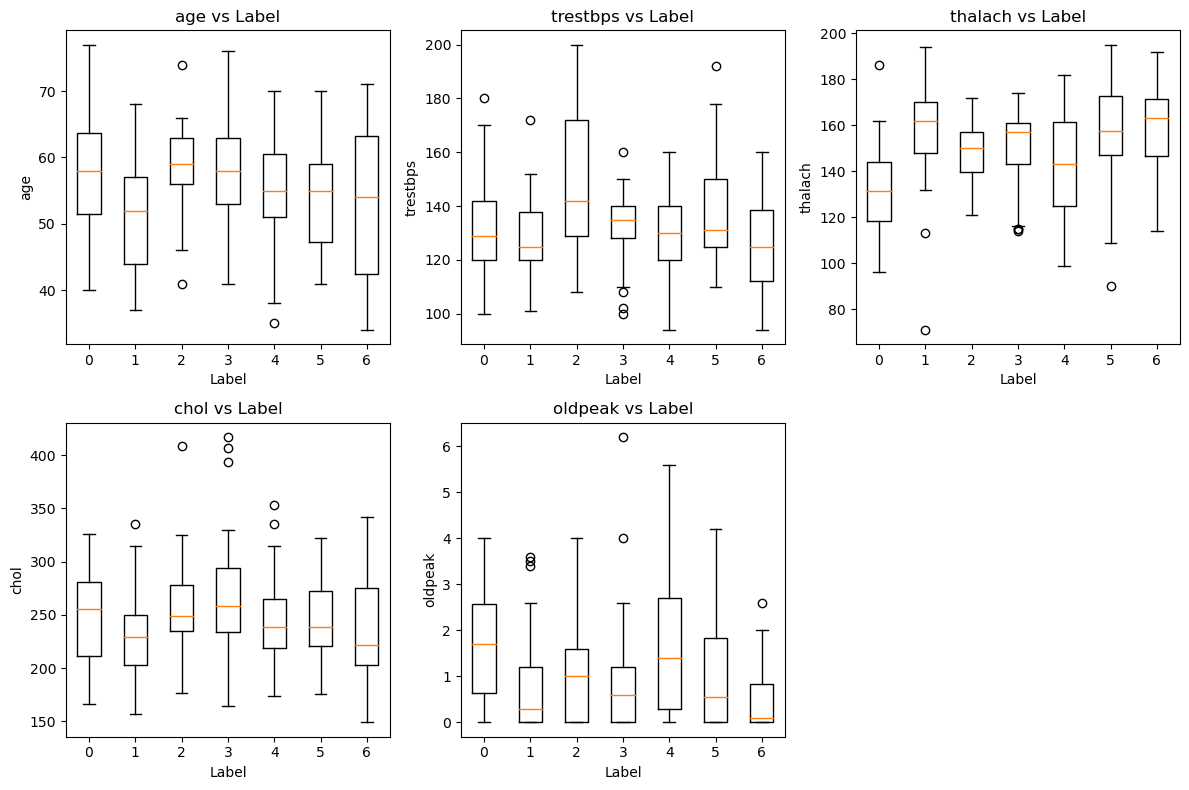

In [260]:
# columns = df_mv_final_medians.columns[df_mv_final_medians.columns != "label"]
columns = ['age', 'trestbps', 'thalach', 'chol', 'oldpeak']

# calculate the number of rows needed
num_rows = (len(columns) + 2) // 3 

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
axs = axs.flatten()

for i, col in enumerate(columns):
    # create the boxplot for the current column against the "label" column
    axs[i].boxplot([final[col][final["label"] == label] for label in sorted(final["label"].unique())])
    
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel(col)
    
    axs[i].set_xticklabels(sorted(final["label"].unique()))
    axs[i].set_title(f"{col} vs Label")

# remove any unused subplots
if len(columns) < len(axs):
    for j in range(len(columns), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Scatter plots

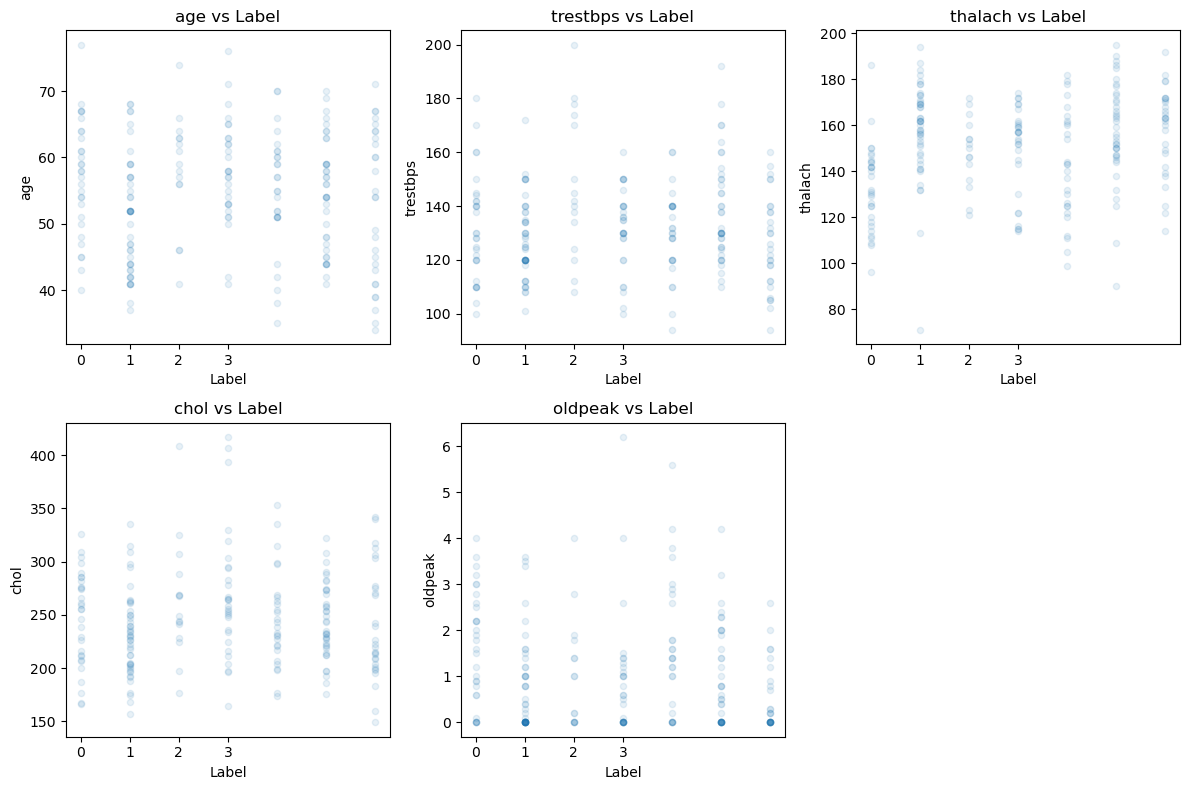

In [261]:
columns = ['age', 'trestbps', 'thalach', 'chol', 'oldpeak']
# columns = df_mv_final_medians.columns[df_mv_final_medians.columns != "label"]

# calculate the number of rows needed
num_rows = (len(columns) + 2) // 3  

# plot the figures
fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
axs = axs.flatten()

for i, col in enumerate(columns):
    axs[i].scatter(final["label"], final[col], s=20, alpha=0.1)  # Set the marker size to 20
    
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel(col)
    
    axs[i].set_xticks([0, 1, 2, 3])
    axs[i].set_title(f"{col} vs Label")

if len(columns) < len(axs):
    for j in range(len(columns), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Modes for not continous columns

In [262]:
exclude_columns = ['age', 'trestbps', 'thalach', 'chol', 'oldpeak', 'label', 'id']
mode_columns = final.columns[~final.columns.isin(exclude_columns)]
column_modes = final.groupby('label')[mode_columns].apply(lambda x: x.mode().iloc[0])
print(column_modes)

0      sex   cp  fbs  restecg  exang  slope
label                                      
0      1.0  4.0  0.0      2.0    1.0    2.0
1      1.0  3.0  0.0      0.0    0.0    1.0
2      0.0  4.0  0.0      2.0    1.0    2.0
3      0.0  4.0  0.0      2.0    0.0    1.0
4      1.0  4.0  0.0      0.0    1.0    2.0
5      1.0  4.0  0.0      2.0    0.0    1.0
6      0.0  3.0  0.0      0.0    0.0    1.0


Means for not continous columns

In [263]:
exclude_columns = ['age', 'trestbps', 'thalach', 'chol', 'oldpeak', 'label', 'id']
mode_columns = final.columns[~final.columns.isin(exclude_columns)]
column_modes = final.groupby('label')[mode_columns].mean()
print(column_modes)

       sex        cp       fbs   restecg  exang     slope
label                                                    
0      1.0  3.833333  0.100000  2.000000    1.0  1.833333
1      1.0  2.755556  0.200000  0.000000    0.0  1.422222
2      0.0  3.733333  0.200000  1.066667    1.0  1.933333
3      0.0  3.172414  0.137931  1.965517    0.0  1.551724
4      1.0  3.444444  0.111111  0.000000    1.0  1.703704
5      1.0  2.736842  0.105263  2.000000    0.0  1.631579
6      0.0  2.750000  0.000000  0.000000    0.0  1.357143


TEST

In [265]:
df_test = pd.read_csv('test.csv')
raw_data_test = df_test.copy()
df_test = preprocessing(df_test, rem_over=True, rep_out=False, encode=False, process='minmax')

In [267]:
df_kmeans_test, model = k_means_alg(df_test, num_clusters=7)
y_kmeans_test = df_kmeans_test['label']

Number of clusters: 7


In [270]:
final_test_medians = raw_data_test.copy()
final_test_medians['label'] = y_kmeans_test
print(medians_for_clusters(final_test_medians))
print(means_for_clusters(final_test_medians))

          id   age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  \
label                                                                         
0      172.0  60.0  1.0  2.5     150.0  222.5  1.0      2.0    135.5    0.0   
1      120.0  60.0  1.0  3.0     135.0  254.0  0.0      2.0    155.0    0.0   
2      187.0  57.5  1.0  4.0     122.5  206.0  0.0      2.0    129.0    1.0   
3      137.5  48.5  1.0  3.0     127.0  233.5  0.0      0.0    167.0    0.0   
4      199.0  50.0  0.0  3.0     120.0  244.0  0.0      0.0    162.0    0.0   
5      169.0  55.5  0.0  3.5     139.0  306.5  0.0      2.0    156.0    0.0   
6      119.0  56.0  1.0  4.0     130.0  283.0  1.0      2.0    136.0    1.0   

       oldpeak  slope  
label                  
0         0.05    1.5  
1         0.40    2.0  
2         1.35    2.0  
3         0.15    1.0  
4         0.00    1.0  
5         0.85    1.5  
6         1.60    2.0  
               id        age  sex        cp    trestbps        chol     

In [271]:
for metric in metrices:
    print(f'{metric}: {metrices[metric](df_test, y_kmeans_test)}')

Minimal distance between clusters: 0.9922968929742194
Average distance between points in the same class: 0.9217186375194766
Standard deviation of distance between points in the same class: 0.11521549818900209
Silhouette score: 0.3149350068163209
Calinski-Harabasz index: 13.349315399650472
Davies Bouldin index: 1.1325244753438624
